In this project data i have selected Census 2000 PUMS data for 10 different states.
States selected for analysis are:
states = 'Alabama','Louisiana','Mississippi','Montana','Texas','Hawaii','Alaska','California','Idaho','New_Jersey'


In [2]:
from read_in_census_data import CensusInfo, DataFrameWrapper
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Creating file name for each State 

In [3]:
merge_state_data=[]
file_name='revisedpums1_'
csv_f_name = '_pums_extract.csv'

In [4]:
data_dictionary = '5%_PUMS_record_layout.xls'
ci = CensusInfo (data_dictionary)
dt_dict ={'serial_no':object,'race':object,'gender':object,'relationship':object}

Processing 'Housing Unit Record' Sheet

Processing 'Person Record' Sheet



Running a Loop to read all the data from each State File and merging it to single dataframe
All of the above 10 state files are in the text format with a hierarchical structure with housing unit record and the person record. For each of the state file only required subset of columns are selected such as Race, Education, Income, Gender, Age, Relationship. 
The records are stored in a CSV file. 
The records are read from CSV file which is now formatted with headers.
All of the state file records are appended into a single data frame with new column State representing the name of the state to which these records belong.

In [5]:
states = ['Alabama','Louisiana','Mississippi','Montana','Texas','Hawaii','Alaska','California','Idaho','New_Jersey']
for state in states:
    one_percent_data_file = file_name+state+'.txt'
    df = DataFrameWrapper(ci)
    # we select a subset of the columns that are needed.
    df.fill_frame ([], ci.person_record, one_percent_data_file, ci.one_percent_file, \
                'race','education','income','gender','age','relationship')
    csv_file_name = state+csv_f_name
    df.save_frame(csv_file_name,header=True)
   
    state_data = pd.read_csv(csv_file_name,dtype=dt_dict)
    state_data['state']=state
    merge_state_data.append(state_data)

Concatenate all the data into single dataframe

In [6]:
all_state_data = pd.concat(merge_state_data, ignore_index=True)    
#all_state_data.to_csv('all_state_pums_extract3.csv')

Creating Bins for Education Levels
To represent different levels of education the Education field is mapped into a new field Degrees which consist of following bins:
1)	Less than High School where educational attainment is less than 9th grade
2)	High School not Completed where educational attainment is between 9th -12th grade
3)	High School Diploma 
4)	College Student with No Degree 
5)	Associate Degree
6)	Bachelor`s Degree
7)	Master’s Degree
8)	Professional Degree
9)	Doctorate Degree

In [7]:
def education (x):
    
    if 1<=x<5:
        return 'Less than High School'
    elif 5<=x<=8:
        return 'High School not Completed'
    elif x == 9:
        return 'High School Diploma'
    elif 10<=x<=11:
        return 'College, no Degree'
    elif x == 12:
        return 'Associate`s Degree'
    elif x == 13:
        return 'Bachelor`s Degree'
    elif x == 14:
        return 'Master`s Degree'
    elif x == 15:
        return 'Professional Degree'
    elif x == 16:
        return 'Doctorate Degree'
    else:
        return 'ND' 


Select all rows with Income greater than zero
Education is mapped into above mentioned bins as new column ‘Degrees’:


In [8]:
data_w_income = all_state_data.loc[all_state_data['income']>0]
data_w_income['degrees'] = data_w_income['education'].map(education)
dis_df = data_w_income.loc[:,['degrees','income','state']]


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Then Median Income is calculated by Degrees for each state. This can be achieved by grouping data by state and degrees and then calculating the Median Income.

In [9]:
grouped_df = dis_df.groupby(['state','degrees'],as_index=False).median()

Using Median Income, a Line Graph is plotted which shows median income(y-axis) in all of the states (x-axis) where colored lines indicate various education level. 

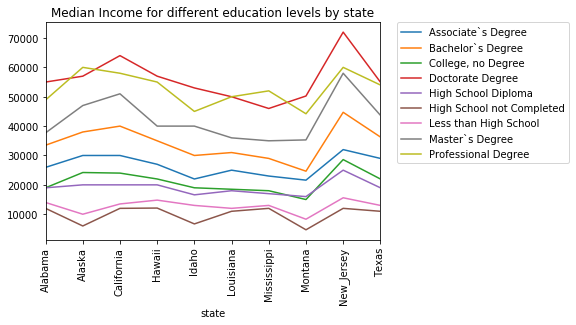

In [10]:

grouped_df.pivot("state","degrees","income").plot(kind='line')
plt.title("Median Income for different education levels by state")
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

The highest level of education such as a Doctorate and Professional Degree have Median income approximately 5-10 times more than the lower education levels such as High School not completed. We can plot a horizontal bar chart as below to visualize it.

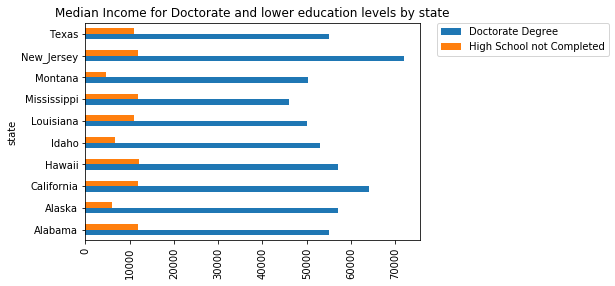

In [11]:
degree_H_L = grouped_df[(grouped_df.degrees.isin(['Doctorate Degree','High School not Completed']))]
degree_H_L.pivot("state","degrees","income").plot(kind='barh')
plt.title("Median Income for Doctorate and lower education levels by state")
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

From the Above Graph we can see that states like Alaska and Montana the Median Income for Doctorate Degree is 10 times more than that for High School not completed. For states like California, Louisiana the Median Income for Doctorate Degree is 5 times more than that for High School not completed.


The State of New Jersey and California have higher median Income than most of the states. We can plot a bar graph to study Income difference for states of California and New Jersey.

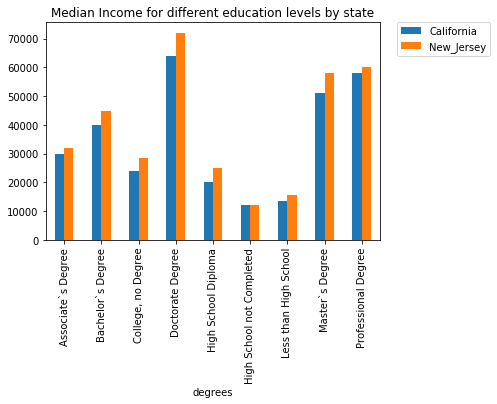

In [12]:
state_C_NJ = grouped_df[(grouped_df.state.isin(['California','New_Jersey']))]
state_C_NJ.pivot("degrees","state","income").plot(kind='bar')
plt.title("Median Income for different education levels by state")
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


New Jersey state has higher median Income for most of the Education levels except for the education level High School not completed where the Median Income is same for California and New Jersey. For Professional Degree there is a marginal difference in median Income in both the states. Also, the Professional Degree Income in the state of California is higher than the Income for Master`s degree. For the New Jersey state the Median Income difference for Master`s Degree and Professional degree is not significant.

From the Line graph we can observe that Doctorate Degree has higher Median Income for most of the states except for states like Louisiana, Texas, Alaska and Mississippi. Therefore, we compare the incomes of the doctorate and professional degrees by plotting a boxplot these states.

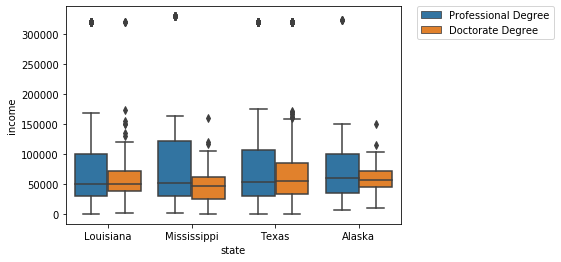

In [13]:
state_L_T=dis_df[(dis_df.state.isin(['Louisiana','Texas','Alaska','Mississippi'])) & (dis_df.degrees.isin(['Professional Degree','Doctorate Degree']))]
sns.boxplot(x = "state",y = "income" ,hue="degrees", data = state_L_T)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

From the Boxplot we can observe that the median incomes for Professional degrees has higher distribution of Income for all of the 4 states. But the median Income in almost equal to the doctorate degree incomes for Louisiana and Texas. Whereas for Mississippi and Alaska the median Income for Professional Degree is higher than that of Doctorate Degree. This might be due to the higher salary commanded by professional degree holders working on offshore oil rigs and other similar high-risk jobs.

The Median Income for people with education level of “Less than High School” have more median Income than people with Education level of “High School not Completed” for all of the 10 states. Bar chart can be used to visualize this data.

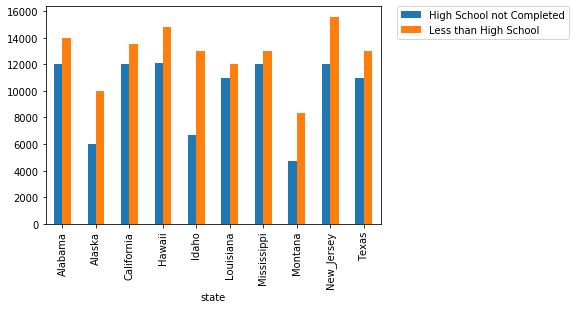

In [14]:
state_9th=dis_df[(dis_df.degrees.isin(['Less than High School','High School not Completed']))]
grouped_9th = state_9th.groupby(['degrees','state'],as_index=False).median()
grouped_9th.pivot("state","degrees","income").plot(kind='bar')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

We can observe that there is a significant difference in Income between “Less than High School” and “High School not Completed” education levels in states like Idaho Alaska and Montana.

Part 2:
Compare income levels for a variety of levels of education for whites and non-whites

For this part the income levels for a variety of levels of education for whites and non-whites are compared. Whites and Non-Whites are identified using a “get_race” function. The function “get_Race” returns Race as ‘White’ if the value in the argument being passed is ‘47’. For any other value it returns as ‘Non-White’.


In [15]:

def get_race(x):
    if x == '47':
        return 'White'
    else:
        return 'Non White'

In [16]:
data_w_income['white_only']  = data_w_income['race'].map(get_race)     
white_data = data_w_income.loc[:,['degrees','income','state','white_only']]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Bar Chart is plotted for state of Alabama,Alaska and Idaho to compare the income levels for a variety of 
levels of education for white and non-white population.

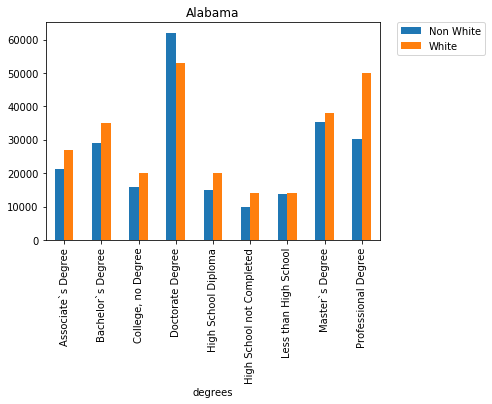

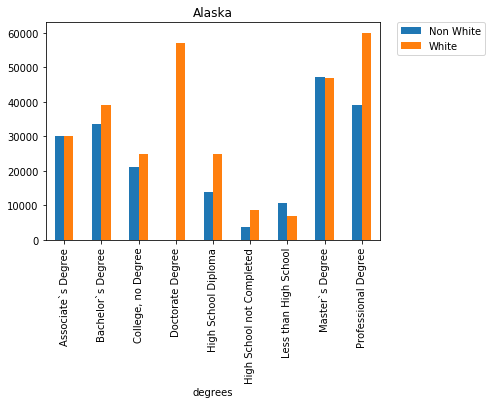

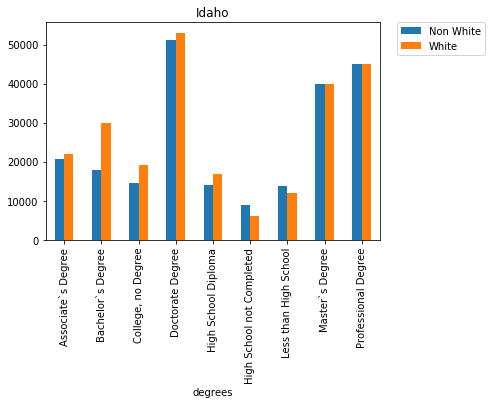

In [18]:

states =['Alabama','Alaska','Idaho']
for s in states:
    state_data = white_data[(white_data.state.isin([s]))]
    grouped_white = state_data.groupby(['degrees','white_only'],as_index=False).median()
    grouped_white.pivot("degrees","white_only","income").plot(kind='bar')
    plt.title(s)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

For Alabama the median Income for White population is higher for most of the education levels except for Doctorate Degree where the Non-White Population have higher median Income and population with Less than High School have an approximately similar median income range. There is significant difference in the median Income for the White population for Professional Degree than the Non-White Population.

For Idaho  the Lower Education levels have higher 
median Income for the Non-White population. For Masters and Professional Degree, the median Income is same. For Doctorate Degree too there is not much of a significant difference. Whereas for bachelor’s and High School not Completed the White population has more median Income.


A surprising observation can be seen for the state of Alaska. There is no Income data for Non-White population for Doctorate Degree. Master’s degree and Professional Degree Median Income is same for White and Non-White population but for Professional Degree there is considerable difference in the median Income between White and non-White population.

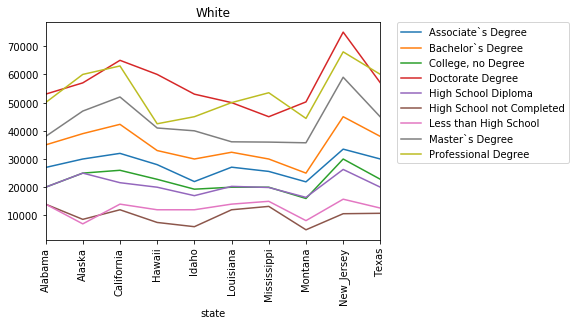

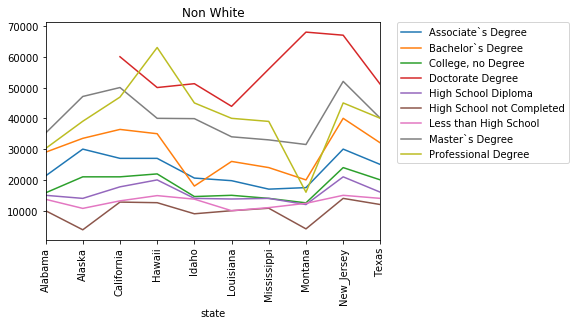

In [19]:
for race in white_data.white_only.unique():
    w_data = white_data[white_data.white_only.isin([race])]
    grp_data = w_data.groupby(['state','degrees'],as_index=False).median()
    grp_data.pivot("state","degrees","income").plot(kind='line')
    plt.xticks(rotation=90)
    plt.title(race)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()
    

A Line Graph can be plotted for different education levels to view a clear discrepancy in the Income between the White and Non-White population.
Following Line Graph are for following education levels:
1. Doctorate Degree
2. Professional Degree
3. Associate`s Degree

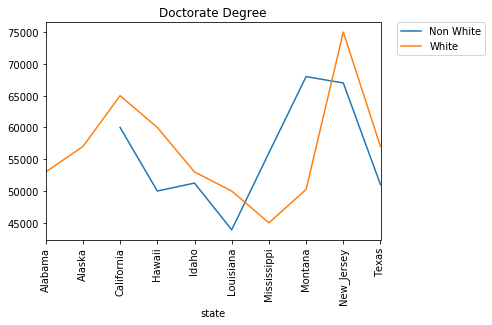

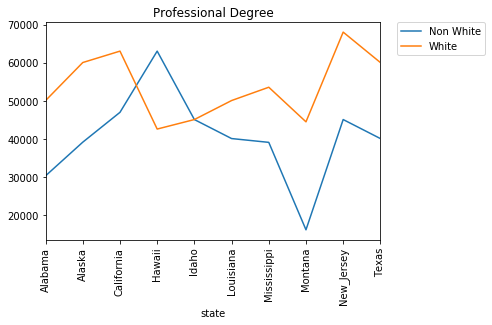

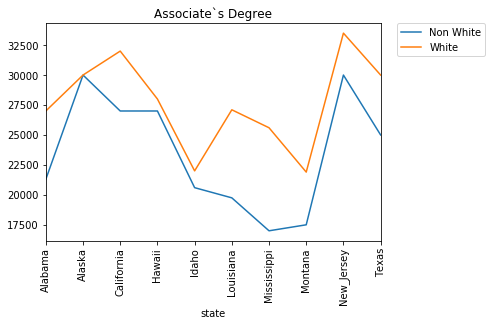

In [20]:
profession = ['Doctorate Degree','Professional Degree','Associate`s Degree']

for p in profession:
    d_data = white_data[white_data.degrees.isin([p])]
    grouped_d_o = d_data.groupby(['state','white_only'],as_index=False).median()
    grouped_d_o.pivot("state","white_only","income").plot(kind='line')
    plt.xticks(rotation=90)
    plt.title(p)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()
 

The Income levels for the Doctorate Degree across the 10 
states. Most of the states have a higher median income for the White population except 
for states like Alabama, Mississippi and Montana where the non-white population have a 
considerably higher median income.


For Professional Degree except for Hawaii and Idaho all the other states have a higher 
median income for the White Population.

Associates Degree have higher median income for White population throughout all of 
the states.
